# EE258 Project

Dataset : https://www.kaggle.com/crowww/a-large-scale-fish-dataset

Code References : https://www.tensorflow.org/tutorials/load_data/images

### Problem
The problem we hope to solve is creating an image classification model able to identify different types of fish or seafood at local supermarkets. The model will be able to identify at least 6 different classes of fish or seafood, with all other classes considered as "other".

In [1]:
pwd

'c:\\Users\\tickn\\ml\\final_project'

In [2]:
# handle imports

import cv2
import os, glob
import matplotlib.pylab as plt
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
import PIL
import numpy as np
from imageio import imread
import io
import pathlib
# from numba import jit, cuda

In [3]:
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version:",tf.__version__)
print("Keras Version:",keras.__version__)

Tensorflow Version: 2.7.0
Keras Version: 2.7.0


### Dataset

In [4]:
path = 'C:/Users/tickn/ml/final_project/Fish_Dataset/Fish_Dataset_6'
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

9000


The dataset is a total of 9000 445x590 pixel color images of fish with 1000 images per class. The dataset has been augmented per class with photo at different angles, rotated to generate 1000 data points per class. 

In [5]:
batch_size = 32
img_height = 445
img_width = 590

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

Found 9000 files belonging to 6 classes.
Using 7200 files for training.
Found 9000 files belonging to 6 classes.
Using 1800 files for validation.


In [6]:
class_names = train_ds.class_names
for name in class_names:
    print(name)


Black Sea Sprat
Bream
Mullet
Other
Shrimp
Trout


Found 9000 files belonging to 6 classes.
[1000, 2000, 2000, 2000, 1000, 1000, 0, 0, 0]


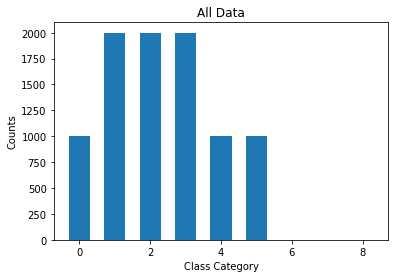

In [7]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
class_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0]
i = 0

all_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height , img_width),
)

for all_img, all_labels in all_data:
    for cat in all_labels:
        class_counts[cat]+=1

print(class_counts)
distribution_data = dict(zip(classes,class_counts))
plt.bar(list(distribution_data.keys()),distribution_data.values(),width =0.6)
plt.title('All Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


#### Outliers

Originally, the dataset provided 2000 images per class. 1000 images were rgb photos of the fish at different angles, augmented by rotating the images around. The other 1000 images per class were black and white photos of the fish outline. These outline images were removed from the dataset resulting in the useful dataset of 9000 rbg images, with 1000 images per class.

### Visualization of Dataset

Below is visualization of each unique class of the dataset and respective class name. Rotated photos illustrate data augmentation done on original photos.

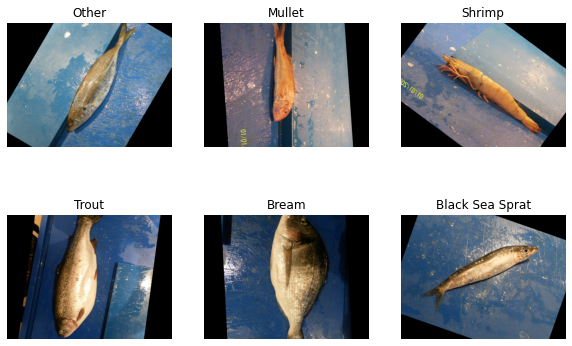

In [8]:
unique = []
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for item in range(len(labels)):
        if labels[item] in unique:
            continue
        else:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[item].numpy().astype("uint8"))
            plt.title(class_names[labels[item]])
            plt.axis("off")

            i+=1
            unique.append(labels[item])
        
    break # run only once through a batch

In [9]:
## Reuse model from HW5

alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu",input_shape=[445,590,3] ),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),

    tf.keras.layers.Dense(6, activation='softmax')
])

## compile the basic model

sgd = keras.optimizers.SGD(learning_rate=0.001)
alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])



In [10]:

history = alt_model.fit(
                    train_ds,
                    batch_size=32, 
                    epochs=50,
                    validation_data =test_ds,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 35s 132ms/step - loss: 318.7912 - accuracy: 0.7135 - val_loss: 0.2668 - val_accuracy: 0.9083
Epoch 2/50
225/225 [==============================] - 28s 123ms/step - loss: 0.1575 - accuracy: 0.9510 - val_loss: 0.1138 - val_accuracy: 0.9639
Epoch 3/50
225/225 [==============================] - 28s 124ms/step - loss: 0.0856 - accuracy: 0.9762 - val_loss: 0.1107 - val_accuracy: 0.9794
Epoch 4/50
225/225 [==============================] - 29s 127ms/step - loss: 0.0558 - accuracy: 0.9865 - val_loss: 0.0413 - val_accuracy: 0.9889
Epoch 5/50
225/225 [==============================] - 29s 128ms/step - loss: 0.0336 - accuracy: 0.9915 - val_loss: 0.0285 - val_accuracy: 0.9922
Epoch 6/50
225/225 [==============================] - 30s 130ms/step - loss: 0.0230 - accuracy: 0.9944 - val_loss: 0.0235 - val_accuracy: 0.9928
Epoch 7/50
225/225 [==============================] - 30s 132ms/step - loss: 0.0152 - accuracy: 0.9967 - val_loss: 0.0270 - val_

In [11]:
alt_model.save('baseline_model.h5')

In [12]:
def create_model():
    alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu",input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

    ## compile the basic model

    sgd = keras.optimizers.SGD(learning_rate=0.001)
    alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])
    return alt_model

In [13]:
model1 = create_model()
model2 = create_model()
model3 = create_model()
model4 = create_model()
model5 = create_model()

In [14]:
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

Found 9000 files belonging to 6 classes.


In [15]:
hold1 = full_ds.shard(num_shards=5, index=0)
hold2 = full_ds.shard(num_shards=5, index=1)
hold3 = full_ds.shard(num_shards=5, index=2)
hold4 = full_ds.shard(num_shards=5, index=3)
hold5 = full_ds.shard(num_shards=5, index=4)

train1 = hold2.concatenate(hold3)
train1 = train1.concatenate(hold4)
train1 = train1.concatenate(hold5)
train2 = hold3.concatenate(hold4)
train2 = train2.concatenate(hold5)
train2 = train2.concatenate(hold1)

train3 = hold4.concatenate(hold5)
train3 = train3.concatenate(hold1)
train3 = train3.concatenate(hold2)

train4 = hold5.concatenate(hold1)
train4 = train4.concatenate(hold2)
train4 = train4.concatenate(hold3)

train5 = hold1.concatenate(hold2)
train5 = train5.concatenate(hold3)
train5 = train5.concatenate(hold4)


In [16]:
history1 = model1.fit(
                    train1,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 110s 485ms/step - loss: 209.3616 - accuracy: 0.7703 - val_loss: 0.1786 - val_accuracy: 0.9419
Epoch 2/50
225/225 [==============================] - 108s 480ms/step - loss: 0.1332 - accuracy: 0.9620 - val_loss: 0.0765 - val_accuracy: 0.9830
Epoch 3/50
225/225 [==============================] - 109s 482ms/step - loss: 0.0661 - accuracy: 0.9810 - val_loss: 0.0607 - val_accuracy: 0.9830
Epoch 4/50
225/225 [==============================] - 110s 488ms/step - loss: 0.0457 - accuracy: 0.9893 - val_loss: 0.0207 - val_accuracy: 0.9962
Epoch 5/50
225/225 [==============================] - 111s 493ms/step - loss: 0.0252 - accuracy: 0.9943 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 6/50
225/225 [==============================] - 111s 492ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 7/50
225/225 [==============================] - 111s 492ms/step - loss: 0.8095 - accuracy: 0.9785 - val_loss: 0.0259

In [17]:
history2 = model2.fit(
                    train2,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 113s 497ms/step - loss: 893685879316898788671488.0000 - accuracy: 0.2083 - val_loss: 1.7889 - val_accuracy: 0.2228
Epoch 2/50
225/225 [==============================] - 111s 490ms/step - loss: 2.3216 - accuracy: 0.2167 - val_loss: 1.7849 - val_accuracy: 0.2272
Epoch 3/50
225/225 [==============================] - 112s 495ms/step - loss: 1.7836 - accuracy: 0.2218 - val_loss: 1.7821 - val_accuracy: 0.2133
Epoch 4/50
225/225 [==============================] - 111s 492ms/step - loss: 1.7809 - accuracy: 0.2107 - val_loss: 1.7798 - val_accuracy: 0.2272
Epoch 5/50
225/225 [==============================] - 111s 490ms/step - loss: 1.7764 - accuracy: 0.2188 - val_loss: 1.7753 - val_accuracy: 0.2328


In [18]:
history3 = model3.fit(
                    train3,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold3,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 113s 497ms/step - loss: 691.8807 - accuracy: 0.7315 - val_loss: 0.3628 - val_accuracy: 0.8867
Epoch 2/50
226/226 [==============================] - 112s 495ms/step - loss: 0.2366 - accuracy: 0.9355 - val_loss: 0.1353 - val_accuracy: 0.9715
Epoch 3/50
226/226 [==============================] - 113s 496ms/step - loss: 0.1300 - accuracy: 0.9664 - val_loss: 0.1072 - val_accuracy: 0.9782
Epoch 4/50
226/226 [==============================] - 112s 492ms/step - loss: 0.1180 - accuracy: 0.9772 - val_loss: 0.0927 - val_accuracy: 0.9738
Epoch 5/50
226/226 [==============================] - 112s 494ms/step - loss: 0.0888 - accuracy: 0.9788 - val_loss: 0.0846 - val_accuracy: 0.9766
Epoch 6/50
226/226 [==============================] - 112s 494ms/step - loss: 0.0765 - accuracy: 0.9825 - val_loss: 0.0713 - val_accuracy: 0.9821
Epoch 7/50
226/226 [==============================] - 112s 496ms/step - loss: 0.0648 - accuracy: 0.9828 - val_loss: 0.0631

In [19]:
history4 = model4.fit(
                    train4,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold4,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 114s 501ms/step - loss: 300.5181 - accuracy: 0.6285 - val_loss: 0.5276 - val_accuracy: 0.8638
Epoch 2/50
226/226 [==============================] - 111s 489ms/step - loss: 0.3846 - accuracy: 0.9084 - val_loss: 0.2056 - val_accuracy: 0.9598
Epoch 3/50
226/226 [==============================] - 112s 493ms/step - loss: 0.1629 - accuracy: 0.9595 - val_loss: 0.1030 - val_accuracy: 0.9682
Epoch 4/50
226/226 [==============================] - 112s 492ms/step - loss: 0.1006 - accuracy: 0.9724 - val_loss: 0.1019 - val_accuracy: 0.9732
Epoch 5/50
226/226 [==============================] - 112s 492ms/step - loss: 0.0984 - accuracy: 0.9727 - val_loss: 0.0785 - val_accuracy: 0.9833
Epoch 6/50
226/226 [==============================] - 112s 490ms/step - loss: 0.0781 - accuracy: 0.9772 - val_loss: 0.0649 - val_accuracy: 0.9849


In [20]:
history5 = model5.fit(
                    train5,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold5,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 112s 492ms/step - loss: 572.8745 - accuracy: 0.5538 - val_loss: 0.5688 - val_accuracy: 0.8666
Epoch 2/50
226/226 [==============================] - 112s 493ms/step - loss: 0.3713 - accuracy: 0.9048 - val_loss: 0.2152 - val_accuracy: 0.9425
Epoch 3/50
226/226 [==============================] - 113s 501ms/step - loss: 0.1437 - accuracy: 0.9635 - val_loss: 0.0920 - val_accuracy: 0.9810
Epoch 4/50
226/226 [==============================] - 113s 500ms/step - loss: 0.1118 - accuracy: 0.9756 - val_loss: 0.0591 - val_accuracy: 0.9939
Epoch 5/50
226/226 [==============================] - 111s 491ms/step - loss: 0.0861 - accuracy: 0.9824 - val_loss: 0.0730 - val_accuracy: 0.9849
Epoch 6/50
226/226 [==============================] - 112s 497ms/step - loss: 0.0739 - accuracy: 0.9835 - val_loss: 0.0755 - val_accuracy: 0.9844
Epoch 7/50
226/226 [==============================] - 112s 493ms/step - loss: 0.0699 - accuracy: 0.9840 - val_loss: 0.0528

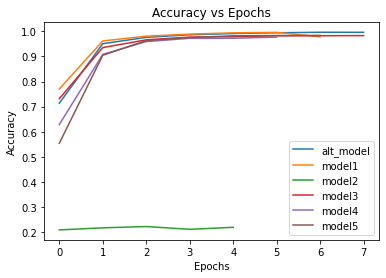

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.plot(history5.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

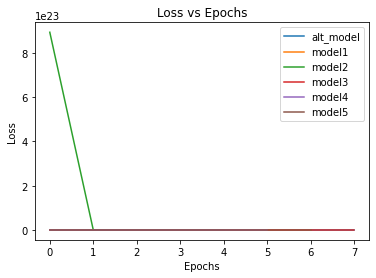

In [22]:
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

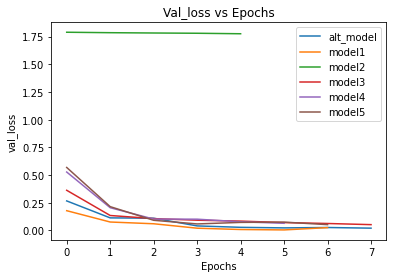

In [23]:
plt.plot(history.history['val_loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

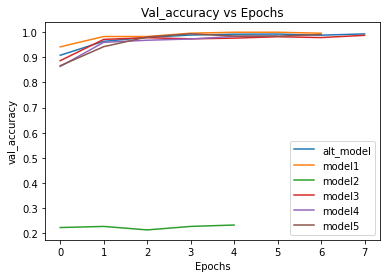

In [24]:
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.title('Val_accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

In [25]:
 model1.save('model1_drop.h5')
 model2.save('model2_drop.h5')
 model3.save('model3_drop.h5')
 model4.save('model4_drop.h5')
 model5.save('model5_drop.h5')